# 03_baseline_models



In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

import statsmodels.formula.api as sm
from pygam import LinearGAM, s, f

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [2]:
file_path = '../data/interim/NYC_capital_projects_3yr.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data = pd.read_csv(file_path)
data_full = pd.read_csv('../data/interim/Capital_Projects_clean.csv') 

In [4]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 149
Number of unique projects in dataset: 149


In [5]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])

In [6]:
data.info()

data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,Current_Project_Year,...,Schedule_Change,Budget_Change,Schedule_Change_Ratio,Budget_Change_Ratio,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Duration_End_Ratio,Budget_End_Ratio,Duration_Ratio_Inv,Budget_Ratio_Inv
0,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,5.94,6,...,91,"-15,619,967.29",0.04,-0.08,0.09,0.08,1.04,0.92,-0.04,0.09
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2-Design,6.34,7,...,334,"9,618,785.30",0.19,0.18,0.15,0.18,1.19,1.18,-0.16,-0.15
2,91,Mill Basin Bridge Replacement,Complete replacement of bascule bridge with a ...,Bridges,Brooklyn,DOT,not_specified,2-Design,7.44,8,...,247,"-34,672,662.00",0.09,-0.09,0.10,0.09,1.09,0.91,-0.08,0.10


## Inspect projects by category

Can any categories be combined to better balance and reduce the number of categories for one-hot-encoding in the baseline model. 

In [7]:
print(
    'The original {} project categories and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Category'].nunique(),
        data['Category'].value_counts()
    )
)

rename_cat_dict = {
    'Bridges, Streets and Roadways': 'Bridges',
    'Parks, Streets and Roadways': 'Parks',
    'Industrial Development, Parks': 'Industrial Development',
    'Other Government Facilities': 'Other Govt Facilities and Improvements',
    'Public Safety and Criminal Justice': 'Other Govt Facilities and Improvements',
    'Arts and Culture': 'Other Govt Facilities and Improvements',
    'Health and Hospitals': 'Other Govt Facilities and Improvements',
}

data['Category_Old'] = data['Category'].copy()
data['Category'] = data['Category'].copy().map(rename_cat_dict).fillna(data['Category'])

print(
    'The newly mapped {} project categories and project counts:\n\n'\
    '{}\n'.format(
        data['Category'].nunique(),
        data['Category'].value_counts()
    )
)

The original 17 project categories and assocated project counts:

Streets and Roadways                  31
Sewers                                20
Schools                               15
Industrial Development                15
Wastewater Treatment                  13
Water Supply                          13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Public Safety and Criminal Justice     4
Other Government Facilities            4
Ferries                                3
Health and Hospitals                   3
Arts and Culture                       2
Parks                                  2
Parks, Streets and Roadways            1
Industrial Development, Parks          1
Name: Category, dtype: int64


The newly mapped 11 project categories and project counts:

Streets and Roadways                      31
Sewers                                    20
Bridges                                   16
Industrial 

In [8]:
print(
    'The original {} managing agencies and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Managing_Agency'].nunique(),
        data['Managing_Agency'].value_counts()
    )
)

The original 7 managing agencies and assocated project counts:

DDC     63
DOT     34
DEP     19
SCA     15
EDC     14
DSNY     2
DCAS     2
Name: Managing_Agency, dtype: int64




In [9]:
print(
    'The original {} client agencies and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Client_Agency'].nunique(),
        data['Client_Agency'].value_counts()
    )
)

The original 19 client agencies and assocated project counts:

DEP                    53
not_specified          35
DOT                    17
DOE                    15
DSNY                    7
DCAS                    4
DPR                     3
H+H                     3
DCLA                    2
ORR                     1
NYPD                    1
BWS                     1
DHS                     1
EDC                     1
DEP, EDC                1
DOHMH, HHC              1
Mayor's Office          1
DSBS                    1
DOT, Mayor's Office     1
Name: Client_Agency, dtype: int64




In [10]:
print(
    'The original {} borough values and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Borough'].nunique(),
        data['Borough'].value_counts()
    )
)

The original 15 borough values and assocated project counts:

not_specified                      47
Brooklyn                           30
Queens                             19
Manhattan                          17
Bronx                              12
Staten Island                       9
Citywide                            5
New York                            2
Valhalla                            2
Manhattan, Staten Island, Bronx     1
Port Jervis                         1
Olive                               1
Marlboro                            1
Manhattan, Bronx                    1
Brooklyn, Queens                    1
Name: Borough, dtype: int64




In [11]:
# One hot encode categorical variables
drop_cat = 'Other Govt Facilities and Improvements'
one_hot = True

data = encode_categories(
    data, colname='Category',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=False
)

data.columns

Index(['PID', 'Project_Name', 'Description', 'Category', 'Borough',
       'Managing_Agency', 'Client_Agency', 'Phase_Start',
       'Current_Project_Years', 'Current_Project_Year', 'Design_Start',
       'Budget_Start', 'Schedule_Start', 'Final_Change_Date',
       'Final_Change_Years', 'Phase_End', 'Budget_End', 'Schedule_End',
       'Number_Changes', 'Duration_Start', 'Duration_End', 'Schedule_Change',
       'Budget_Change', 'Schedule_Change_Ratio', 'Budget_Change_Ratio',
       'Budget_Abs_Per_Error', 'Budget_Rel_Per_Error', 'Duration_End_Ratio',
       'Budget_End_Ratio', 'Duration_Ratio_Inv', 'Budget_Ratio_Inv',
       'Category_Old', 'Bridges', 'Ferries', 'Industrial_Development', 'Parks',
       'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways',
       'Wastewater_Treatment', 'Water_Supply'],
      dtype='object')

In [12]:
# One hot encode categorical variables
drop_cat = 'Other Govt Facilities and Improvements'
one_hot = False

data = encode_categories(
    data, colname='Category',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=False
)

data.columns

Index(['PID', 'Project_Name', 'Description', 'Category', 'Borough',
       'Managing_Agency', 'Client_Agency', 'Phase_Start',
       'Current_Project_Years', 'Current_Project_Year', 'Design_Start',
       'Budget_Start', 'Schedule_Start', 'Final_Change_Date',
       'Final_Change_Years', 'Phase_End', 'Budget_End', 'Schedule_End',
       'Number_Changes', 'Duration_Start', 'Duration_End', 'Schedule_Change',
       'Budget_Change', 'Schedule_Change_Ratio', 'Budget_Change_Ratio',
       'Budget_Abs_Per_Error', 'Budget_Rel_Per_Error', 'Duration_End_Ratio',
       'Budget_End_Ratio', 'Duration_Ratio_Inv', 'Budget_Ratio_Inv',
       'Category_Old', 'Bridges', 'Ferries', 'Industrial_Development', 'Parks',
       'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways',
       'Wastewater_Treatment', 'Water_Supply', 'Category_Code'],
      dtype='object')

In [13]:
random_state = 109
test_size = 0.1

data_train, data_test = train_test_split(
    data,
    test_size=test_size,
    random_state=random_state,
    shuffle=True,
)

In [14]:
print('{}\t{}'.format(data_train.shape, data_test.shape))

(134, 43)	(15, 43)


In [15]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 14 to 6
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   PID                     134 non-null    int64         
 1   Project_Name            134 non-null    object        
 2   Description             134 non-null    object        
 3   Category                134 non-null    object        
 4   Borough                 134 non-null    object        
 5   Managing_Agency         134 non-null    object        
 6   Client_Agency           134 non-null    object        
 7   Phase_Start             134 non-null    object        
 8   Current_Project_Years   134 non-null    float64       
 9   Current_Project_Year    134 non-null    int64         
 10  Design_Start            134 non-null    datetime64[ns]
 11  Budget_Start            134 non-null    float64       
 12  Schedule_Start          134 non-null    datetime64[

In [16]:
data_train['Category'].value_counts()

Streets and Roadways                      24
Sewers                                    17
Bridges                                   16
Industrial Development                    16
Schools                                   15
Other Govt Facilities and Improvements    13
Water Supply                              12
Wastewater Treatment                      11
Sanitation                                 5
Parks                                      3
Ferries                                    2
Name: Category, dtype: int64

In [17]:
data_train.to_csv('../data/interim/NYC_capital_projects_3yr_train.csv', index=True)
data_test.to_csv('../data/interim/NYC_capital_projects_3yr_test.csv', index=True)

## Subset and scale data for X and y frames

In [11]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
    'Category'
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]


In [12]:
X, y = data[X_cols], data[y_cols]

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Budget_Start    149 non-null    float64
 1   Duration_Start  149 non-null    int64  
 2   Category        149 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ KB


In [14]:
# One hot encode categorical variables
drop_cat = 'Other Govt Facilities and Improvements'
one_hot = True

X_ohe = encode_categories(
    X, colname='Category',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True
)

X_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Budget_Start            149 non-null    float64
 1   Duration_Start          149 non-null    int64  
 2   Bridges                 149 non-null    uint8  
 3   Ferries                 149 non-null    uint8  
 4   Industrial_Development  149 non-null    uint8  
 5   Parks                   149 non-null    uint8  
 6   Sanitation              149 non-null    uint8  
 7   Schools                 149 non-null    uint8  
 8   Sewers                  149 non-null    uint8  
 9   Streets_and_Roadways    149 non-null    uint8  
 10  Wastewater_Treatment    149 non-null    uint8  
 11  Water_Supply            149 non-null    uint8  
dtypes: float64(1), int64(1), uint8(10)
memory usage: 3.9 KB


In [15]:
# One hot encode categorical variables
drop_cat = 'Other Govt Facilities and Improvements'
one_hot = False

X_le = encode_categories(
    X, colname='Category',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True
)

X_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Budget_Start    149 non-null    float64
 1   Duration_Start  149 non-null    int64  
 2   Category_Code   149 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 3.6 KB


In [16]:
random_state = 109
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X_ohe, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

X_le_tr, X_le_te, y_train, y_test = train_test_split(
    X_le, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

In [17]:
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t{}'.format(X_test.shape, y_test.shape))

(134, 12)	(134, 2)
(15, 12)	(15, 2)


In [18]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X)[2:]

# # Reset y dataframe indices or else we will run into indexing issues
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)


# Standardize both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_std, Scaler_std = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Perform 'Robust to outliers' standardization on both X_train and X_test
scaler = RobustScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_rstd, Scaler_rstd = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_rstd, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_train_std_sig, Scaler_std_sig = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

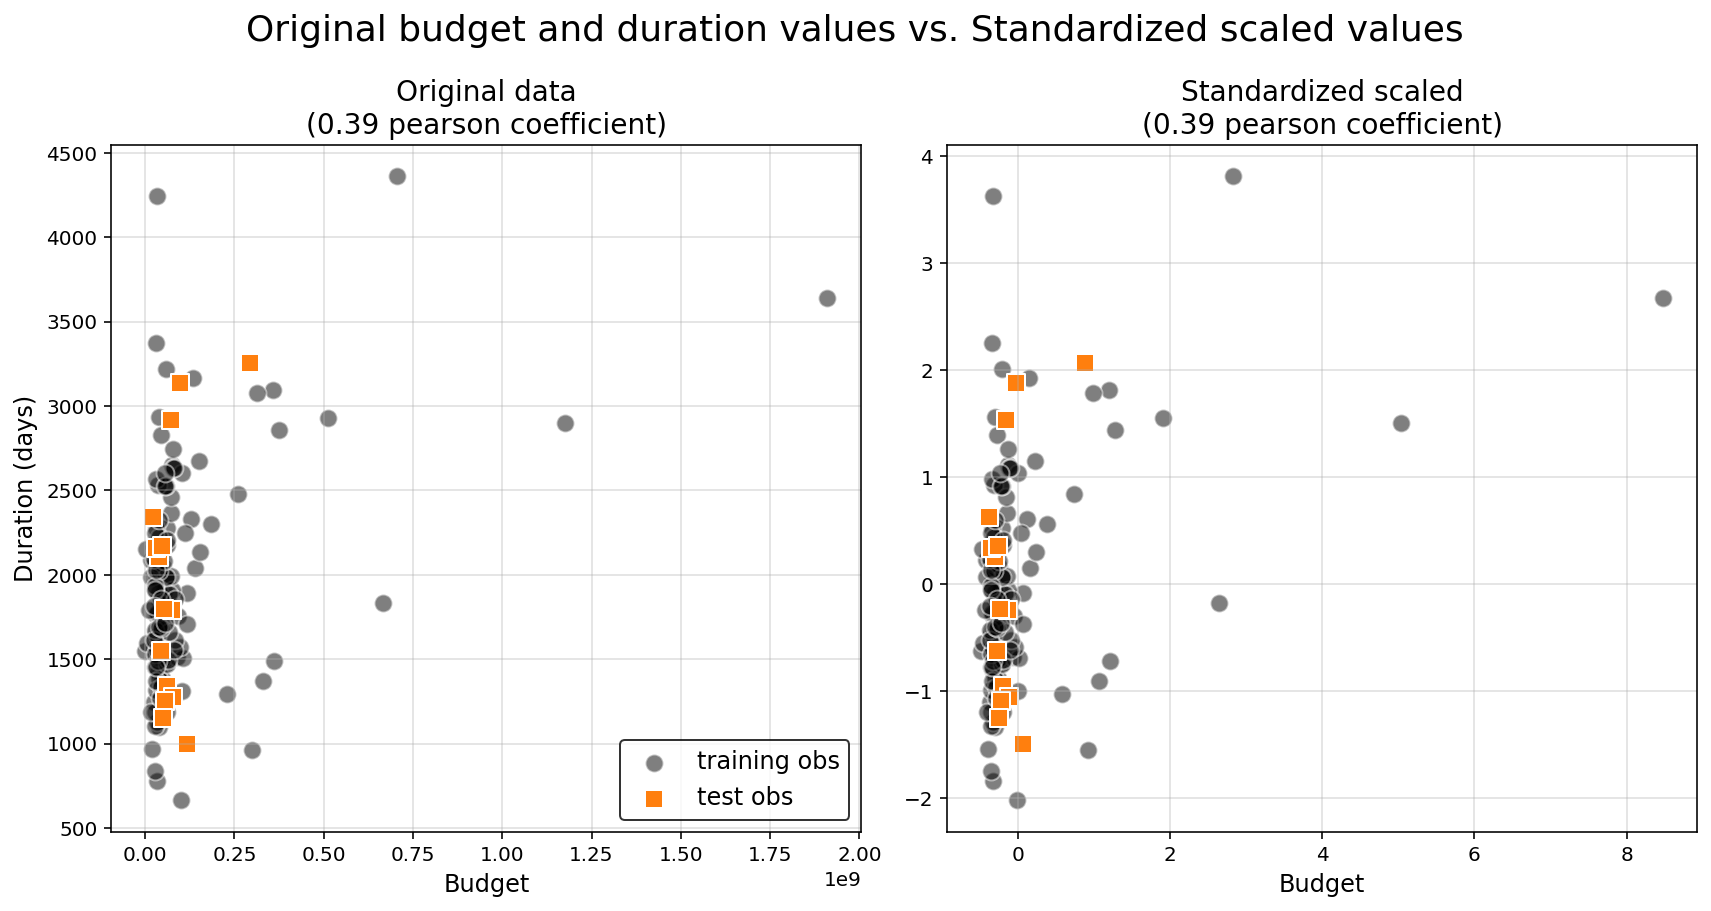

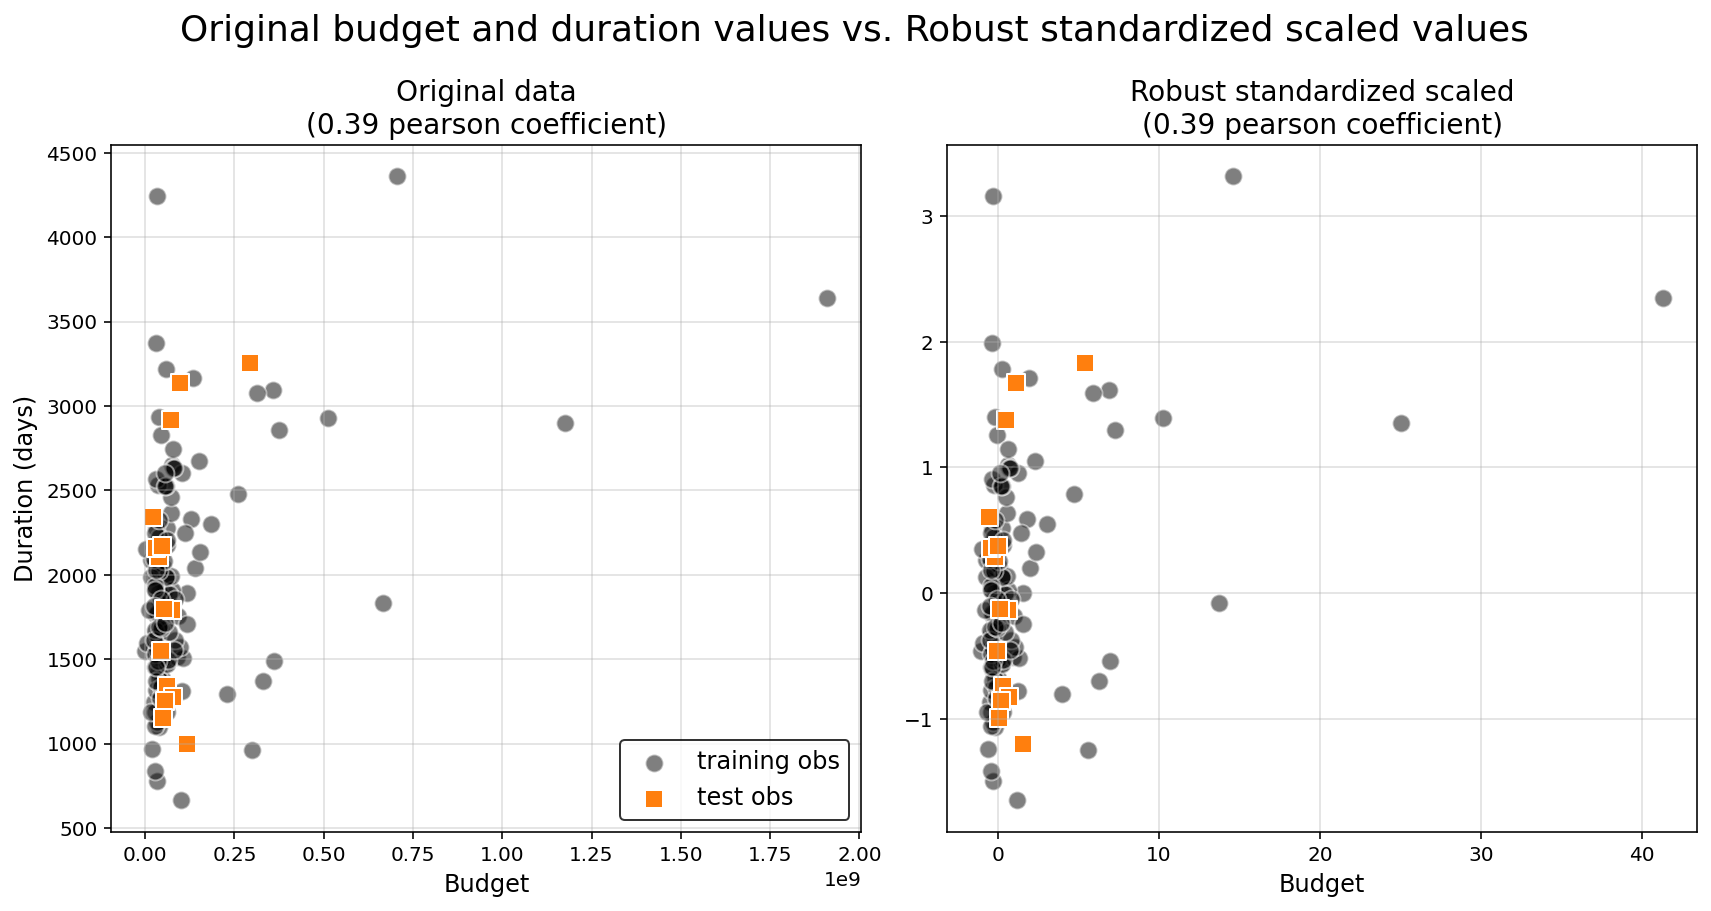

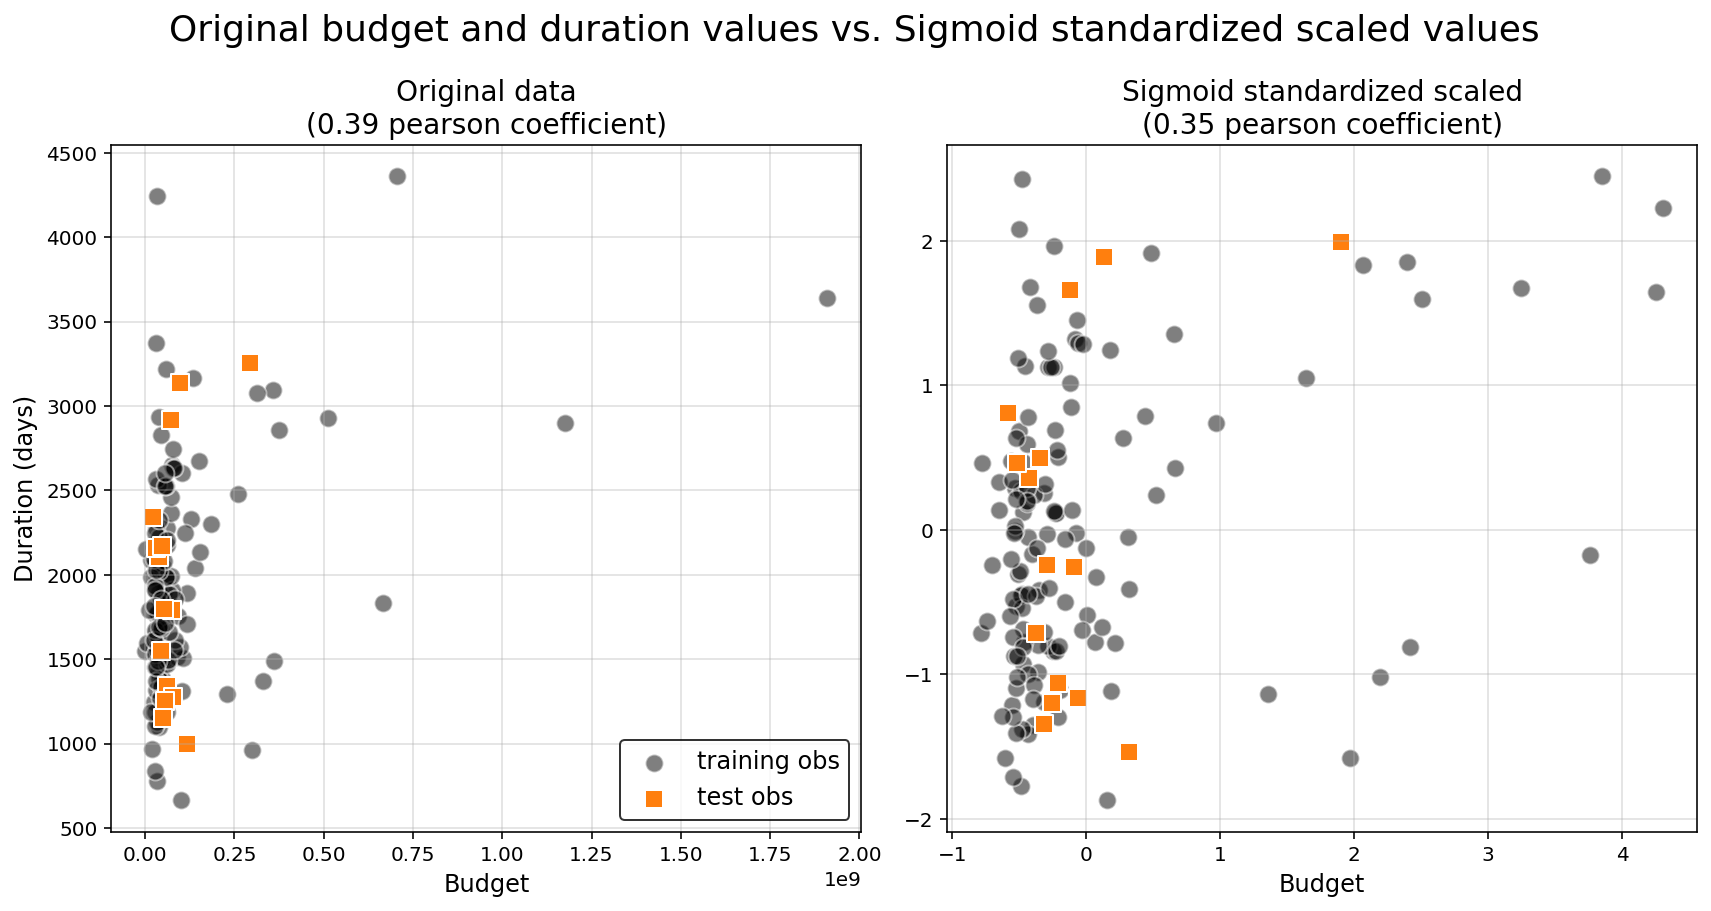

In [19]:
# inspect scaled datasets
plot_bdgt_sched_scaled(X_train, X_train_std, 'Standardized', X_test, X_test_std)
plot_bdgt_sched_scaled(X_train, X_train_rstd, 'Robust standardized', X_test, X_test_rstd)
plot_bdgt_sched_scaled(X_train, X_train_std_sig, 'Sigmoid standardized', X_test, X_test_std_sig)

## Define functions for fitting and evaluating models

In [20]:
# import statsmodels.formula.api as sm

# sm_formulas = [
#     'Budget_Start + Duration_Start + Budget_Start * Duration_Start',
#     'Budget_Start + Duration_Start'
# ]

# model_descr = 'Linear regression with budget change ratio interaction'

# model_LR_norm_log = generate_model_dict(
#     sm.ols,
#     model_descr,
#     X_train, X_test, y_train, y_test,
#     multioutput=True,
#     verbose=False,
#     predictions=True,
#     scores=True,
#     model_api='statsmodels',
#     sm_formulas=sm_formulas
# )

# print_model_results(model_LR_norm_log)

In [21]:
features = [
    'Budget_Start',
    'Duration_Start'
]

model_descr = 'Linear regression unscaled data, baseline'

model_LR = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR)


model_descr = 'Linear regression scaled data, baseline'

model_LR_scaled = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train_std[features], X_test_std[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR_scaled)

model_descr = 'Linear regression robust scaled data, baseline'

model_LR_rscaled = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train_rstd[features], X_test_rstd[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR_rscaled)

model_descr = 'Linear regression sigmoid scaled data, baseline'

model_LR_sigscaled = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR_sigscaled)


MODEL SUMMARY:
Linear regression unscaled data, baseline


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

		Training	0.2260
		Test		0.2391




MODEL SUMMARY:
Linear regression scaled data, baseline


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

		Training	0.2260
		Test		0.2391




MODEL SUMMARY:
Linear regression robust scaled data, baseline


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

In [22]:
features = list(X_train)

model_descr = 'Linear regression unscaled data'

model_LR = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR)


model_descr = 'Linear regression scaled data'

model_LR_scaled = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train_std[features], X_test_std[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR_scaled)


MODEL SUMMARY:
Linear regression unscaled data


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0611
		Test		-2.5771

	Schedule_Change_Ratio

		Training	0.4262
		Test		0.2957




MODEL SUMMARY:
Linear regression scaled data


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0611
		Test		-2.5771

	Schedule_Change_Ratio

		Training	0.4262
		Test		0.2957





In [23]:
features = list(X_train)

model_descr = 'Linear regression sigmoid scaled data'

sm_formulas = [
    ' + '.join(features),
    ' + '.join(features)
]

model_LR_scaled = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)

print_model_results(model_LR_scaled)


MODEL SUMMARY:
Linear regression sigmoid scaled data


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0686
		Test		-2.5340

	Schedule_Change_Ratio

		Training	0.4523
		Test		0.3364





In [24]:
features = list(X_train)

model_descr = 'Linear regression sigmoid scaled data'

sm_formulas = [
    ' + '.join(features) + ' + Budget_Start * Duration_Start',
    ' + '.join(features)
]

model_LR_scaled = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)

print_model_results(model_LR_scaled)


MODEL SUMMARY:
Linear regression sigmoid scaled data


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply + Budget_Start * Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0719
		Test		-2.7048

	Schedule_Change_Ratio

		Training	0.4523
		Test		0.3364





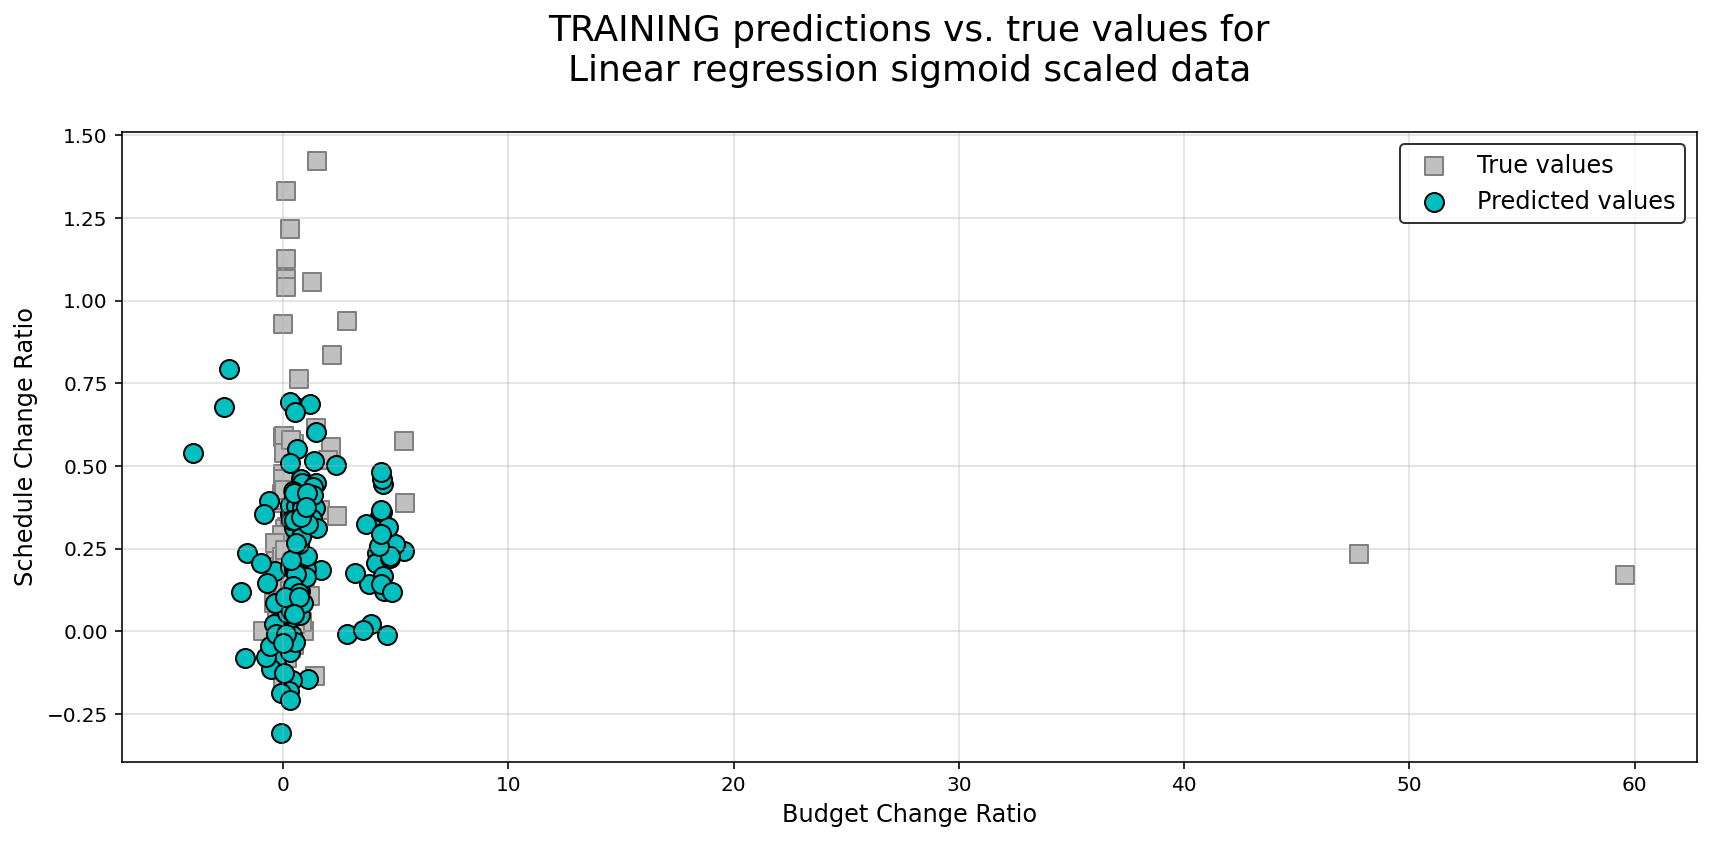

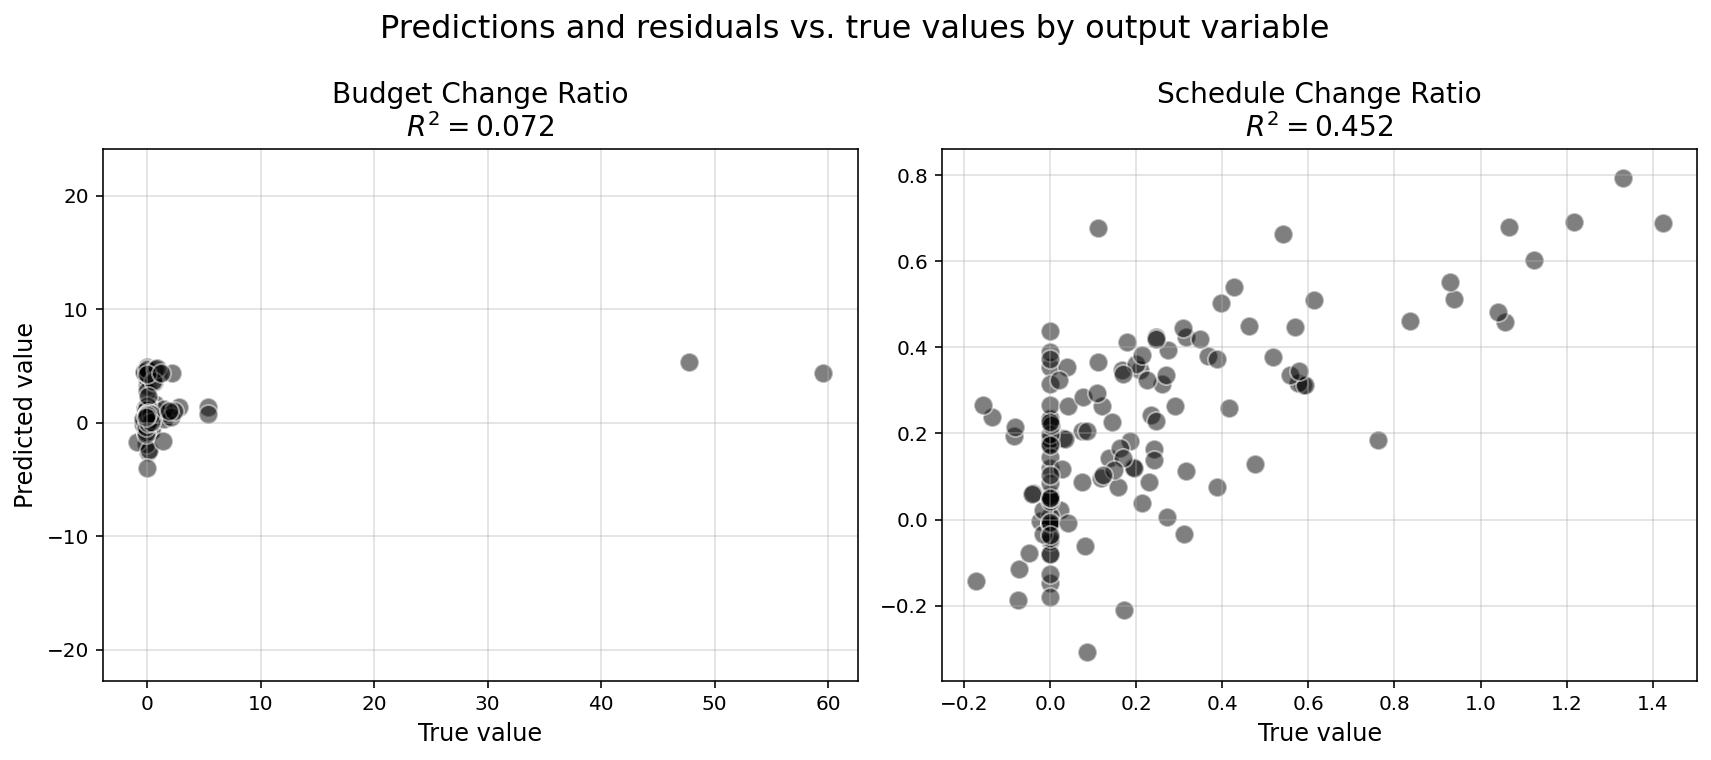

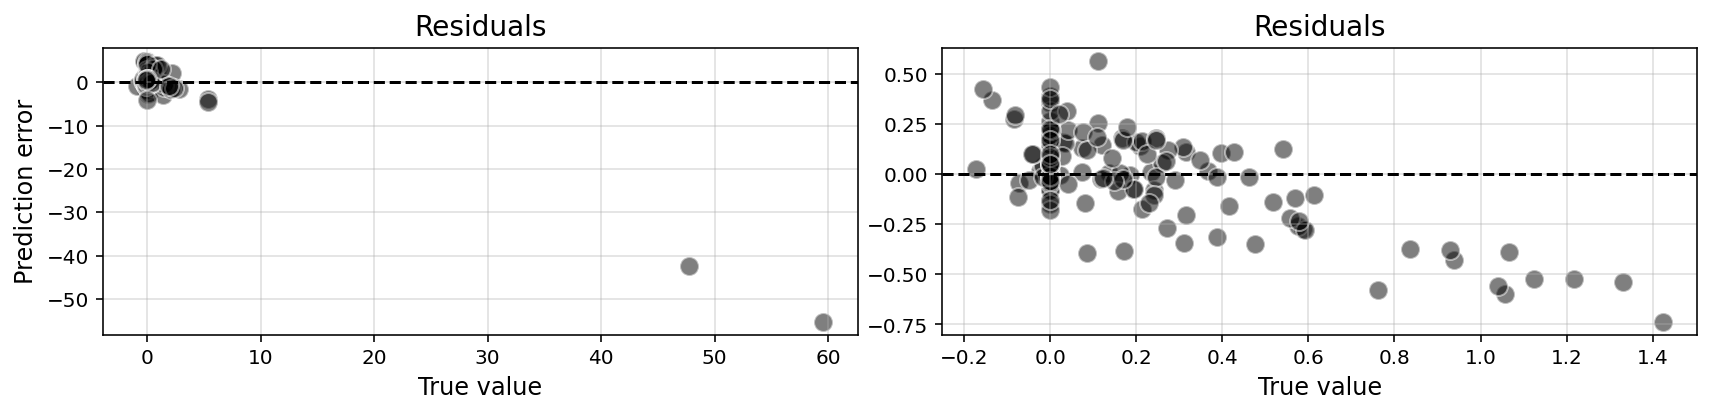

In [25]:
model_descr = 'na'
plot_true_pred(model_dict=model_LR_scaled, dataset='train')

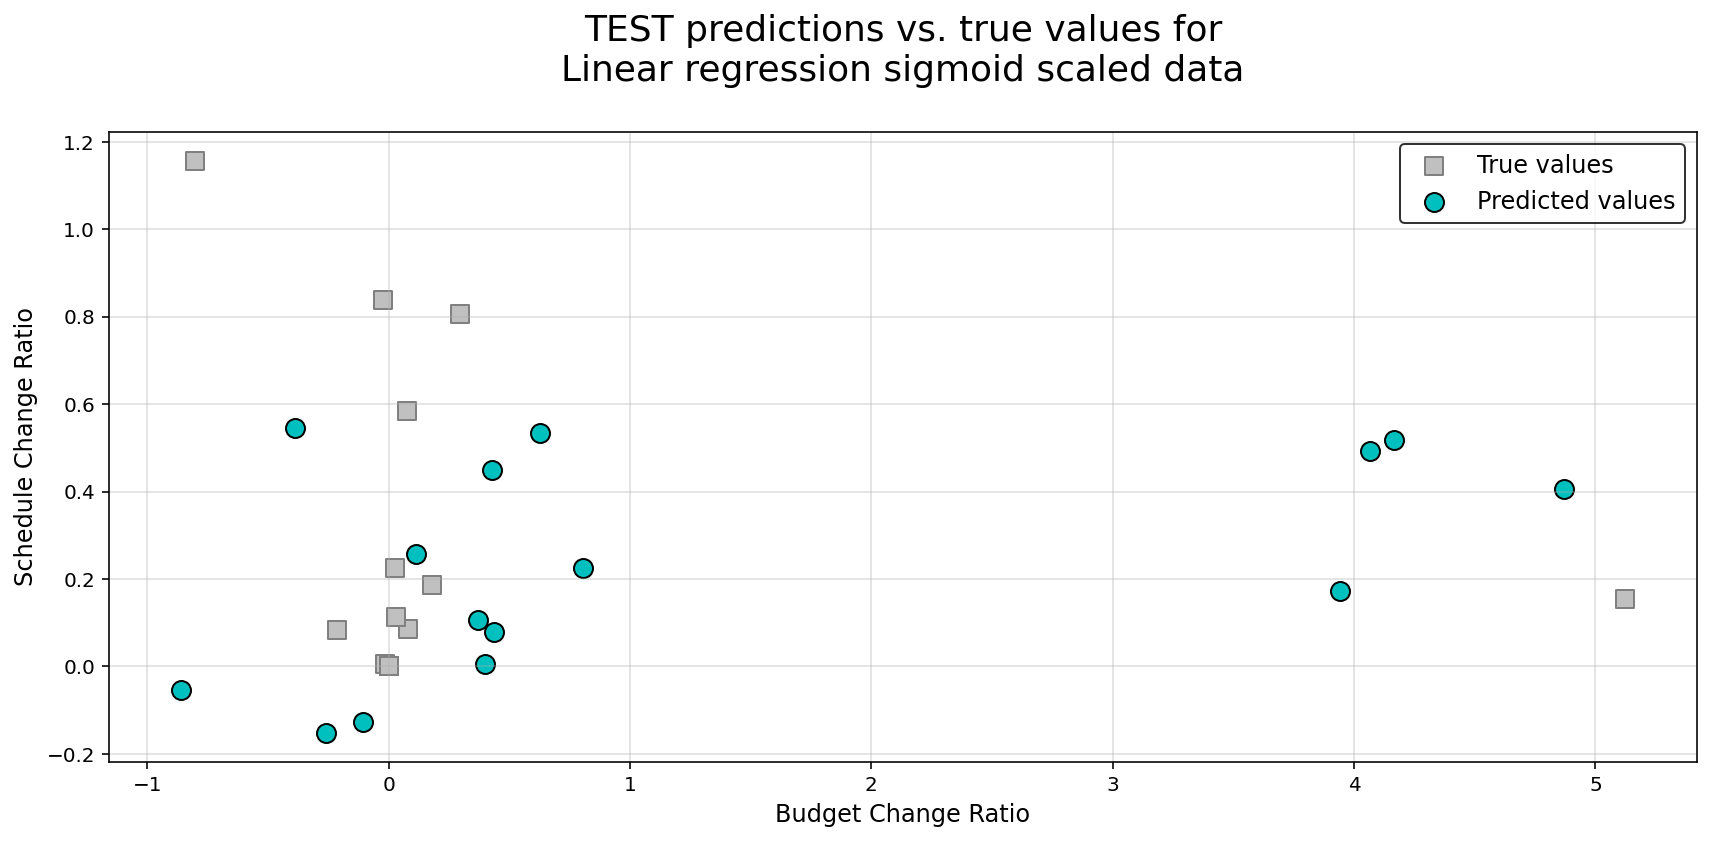

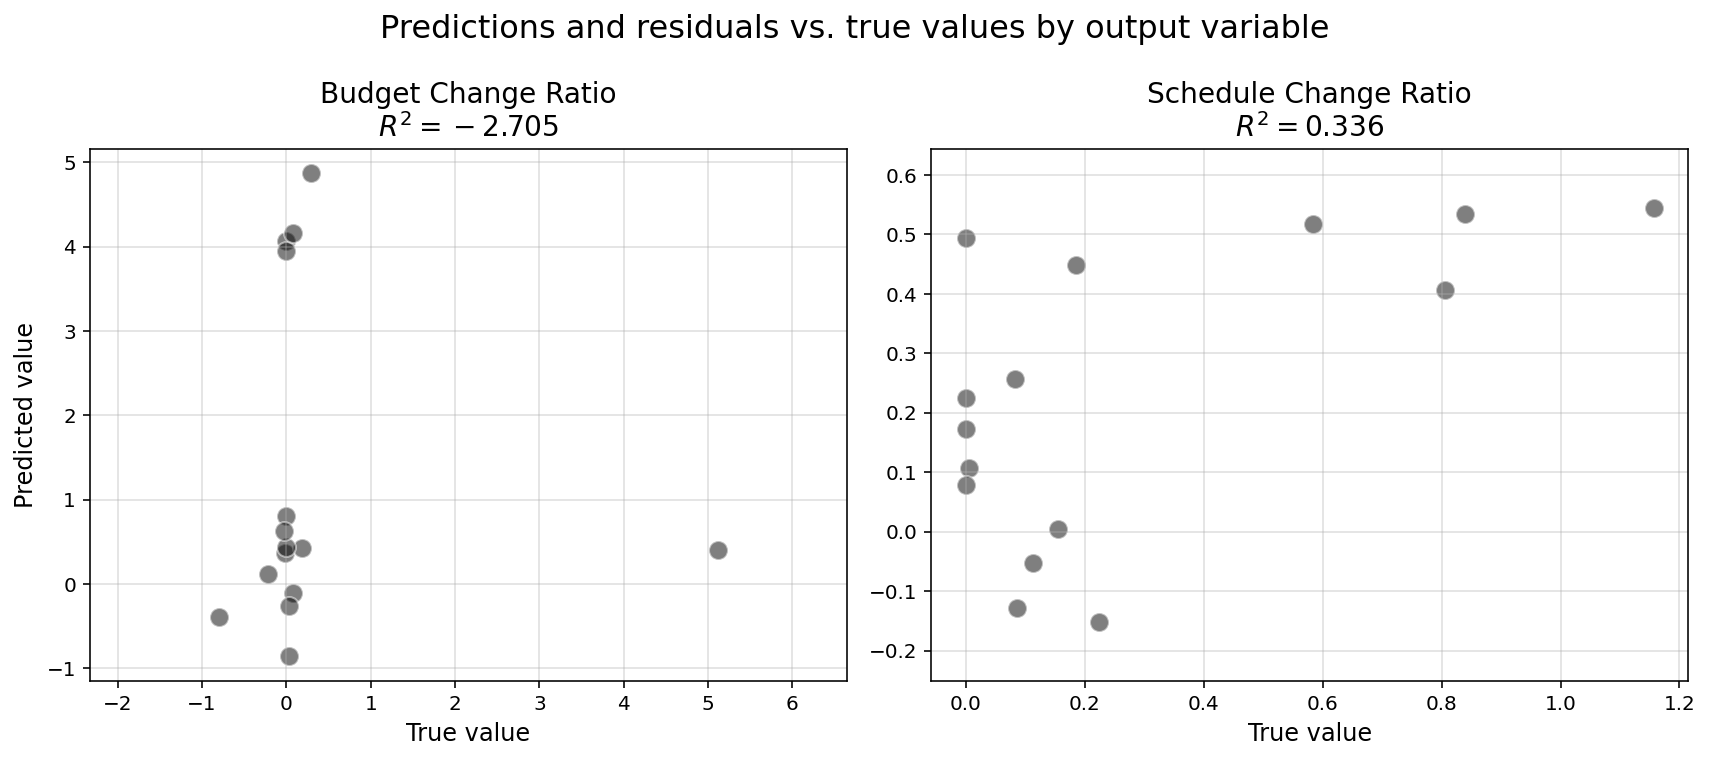

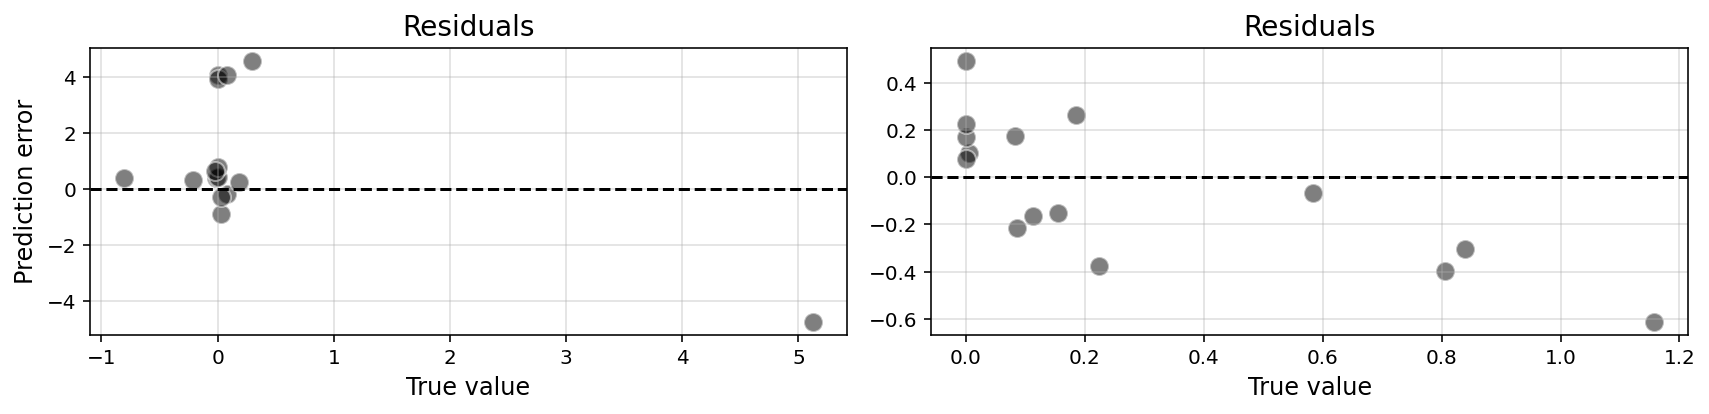

In [26]:
model_descr = 'linear regression with normalized log+1 data linear regression with normalized'
plot_true_pred(model_dict=model_LR_scaled, dataset='test')

In [27]:
data.iloc[y_train['Budget_Change_Ratio'].argmax()]

PID                                                                    593
Project_Name                     Manhattan Bridge Component Rehabilitation
Description              The project includes replacement of finger joi...
Category                                                           Bridges
Borough                                                      not_specified
Managing_Agency                                                        DOT
Client_Agency                                                not_specified
Phase_Start                                                       2-Design
Current_Project_Years                                                 4.99
Current_Project_Year                                                     5
Design_Start                                           2014-09-04 00:00:00
Budget_Start                                                112,110,042.84
Schedule_Start                                         2020-10-30 00:00:00
Final_Change_Date        

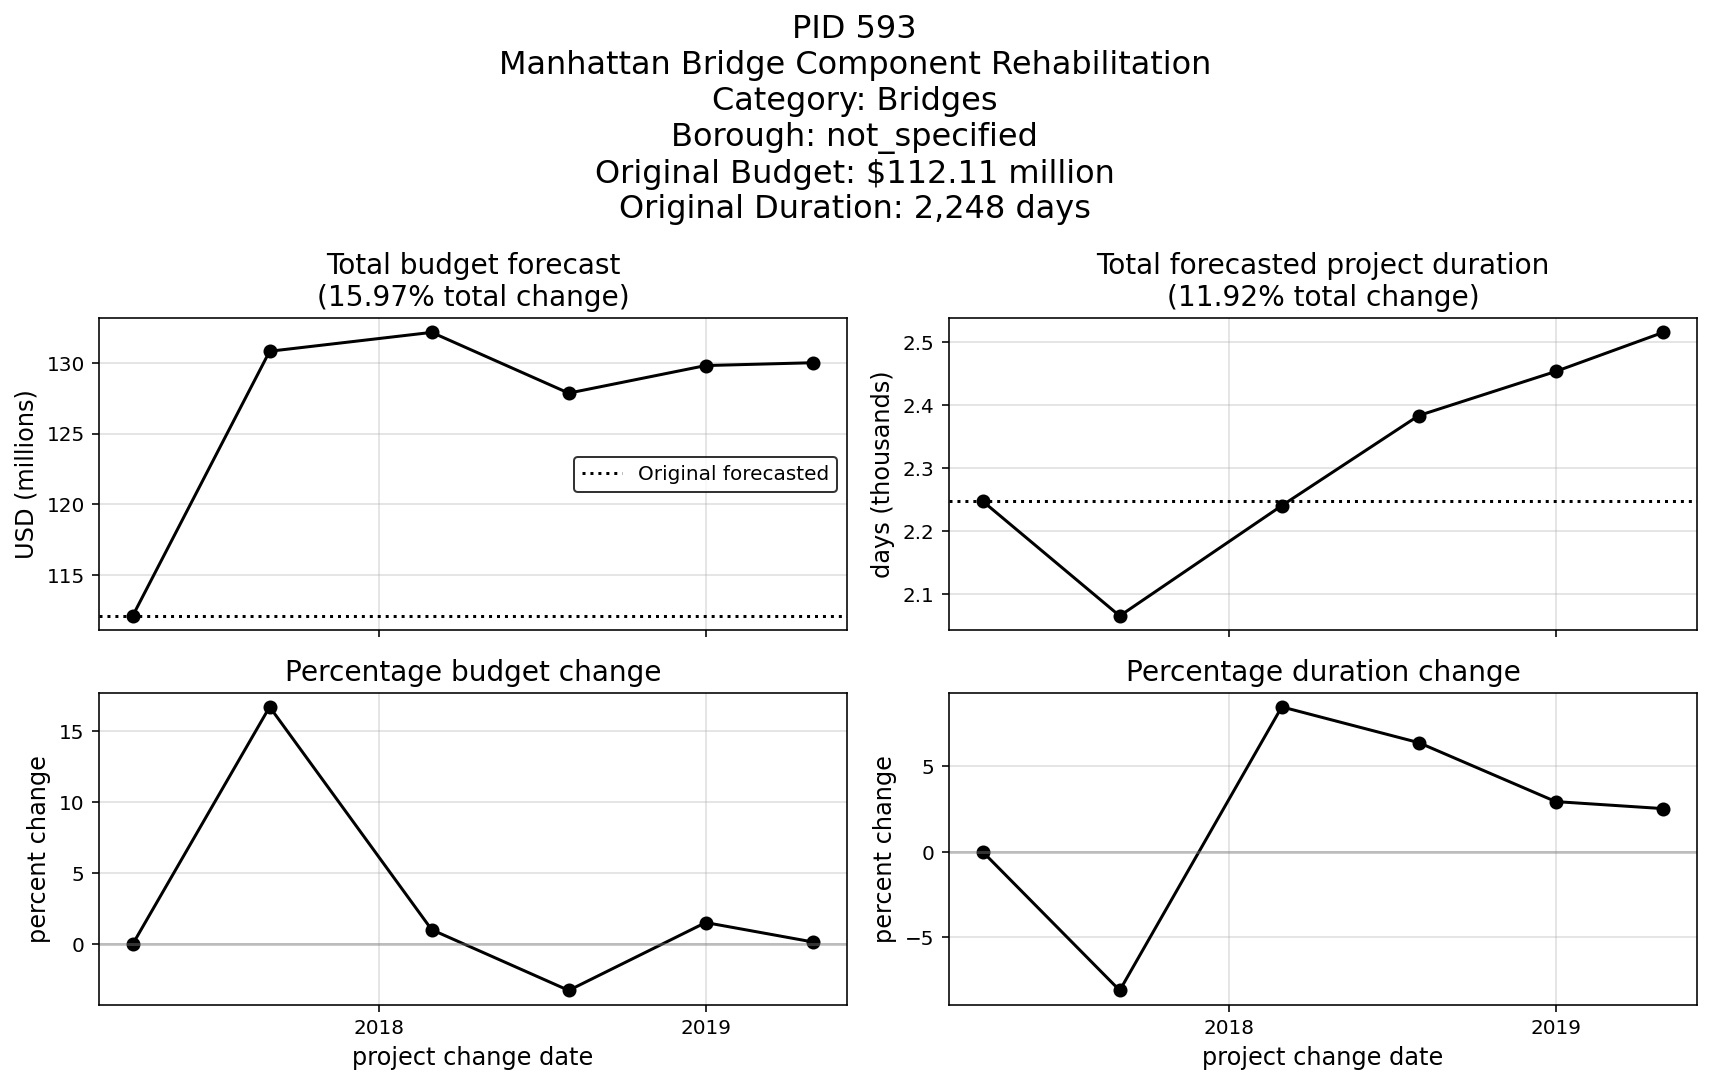

In [28]:
plot_change_trend(data_full, data, 593, None)

# Linear GAM model

In [29]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X_le)[2:]

# # Reset y dataframe indices or else we will run into indexing issues
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)


# Standardize both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_le_tr_std, Scaler_std = scale_features(
    X_le_tr, X_le_tr,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_le_te_std, _ = scale_features(
    X_le_tr, X_le_te,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_le_tr_std_sig, Scaler_std_sig = scale_features(
    X_le_tr, X_le_tr,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_le_te_std_sig, _ = scale_features(
    X_le_tr, X_le_te,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

In [30]:
X_le_tr_std_sig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Budget_Start    134 non-null    float64
 1   Duration_Start  134 non-null    float64
 2   Category_Code   134 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 3.3 KB


In [31]:
X_le_tr_std_sig['Category_Code']

0       7
1       5
2       6
3       6
4       6
       ..
129     6
130    10
131     4
132     5
133     0
Name: Category_Code, Length: 134, dtype: int64

In [32]:
def cv_lineargam_dict(n_splits, lam_list, terms, X_train, y_train,
                      verbose=False, predictions=True, scores=True,
                      kfs_random_state=10):
    """Generates a dictionary of cross-validation pygam LinearGAM models with varying
    values lam

    n_splits: the number of desired cross-validation splits
    lam_list: A list of the desired lam values on which to perform cross-validation
    X_train, X_test, y_train, y_test: the datasets on which to perform cross-validation
    verbose: if True prints each model object to confirm progress (default=False)
    predictions: if True the dict stores model.predict() predictions for both the train
                 and test (i.e. validation) splits in each cv kfold
    kfs_random_state: sets random state for kfold splitter

    return: returns a dictionary object containing the cross-validation models,
            predictions, and scores for each value k and fold, (similar to those
            generated using the generate_fitted_model_dict function above)
    """
    from sklearn.model_selection import KFold
    
    # reset indices to prevent joining and index errors, particularly if using
    # scaled X dataframes
    X_train = X_train.copy().reset_index(drop=True)
    y_train = y_train.copy().reset_index(drop=True)
    
    # create kfold splitter for generating knn cross-validation indices
    KFSplitter = KFold(n_splits=n_splits, shuffle=True, random_state=kfs_random_state)
    
    models_dict = {
        lam: {
            fold: generate_model_dict(
                model=LinearGAM,
                model_descr='Smoothing Spline GAM with lam={}'.format(lam),
                X_train=X_train.iloc[train_index],
                X_test=X_train.iloc[val_index],
                y_train=y_train.iloc[train_index],
                y_test=y_train.iloc[val_index],
                model_api='sklearn', # requires 'sklearn for PyGam'
                multioutput=False, # requires False for PyGam
                verbose=verbose,
                predictions=predictions,
                y_stored=False,
                scores=scores,
                terms=terms,
                lam=lam
            )
            for fold, (train_index, val_index) in enumerate(KFSplitter.split(X_train))
        } for lam in lam_list
    }
    
    return models_dict


def cv_scores_results(cv_model_dict, cv_list, n_splits, version="test"):
    """Generates dataframe of cv scores and mean score per each input value lam
    model_dict: an output CV model dict from the cv_lineargam_dict function
    lam_list: the original list of lam values used for cross-validation
    n_splits: the number of splits included in cross-validation
    version: defaults='test', indicates whether to return CV score results for either
             the 'train' data, or the 'test' (i.e. validation) sets.
    returns: tuple containing (0) pd.dataframe of cv scores, one column for each model,
             one row for each fold and (1) pd.Series of overall cv scores for each
             model
    """

    # create dataframes of scores for both train and val predictions
    scores_df = pd.DataFrame.from_dict(
        {
            cv_val: [
                model_dict[cv_val][fold]['score'][version][1]
                for fold in range(n_splits)
            ] for cv_val in cv_list
        }
    )
    
    return scores_df, scores_df.mean(axis=0)


In [33]:
X_train_std_sig.columns

Index(['Budget_Start', 'Duration_Start', 'Bridges', 'Ferries',
       'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers',
       'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply'],
      dtype='object')

In [34]:
# %%time

# n_splits = 5
# lam_list = np.logspace(-3, 5, 50)
# X_train = X_train_std_sig

# terms = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11)

# cv_models_gam_ohe = cv_lineargam_dict(n_splits, lam_list, terms, X_train, y_train,
#                                       verbose=False, predictions=True, scores=True,
#                                       kfs_random_state=10)

In [35]:
# cv_scores_df, cv_scores = cv_scores_results(cv_models_gam_ohe, lam_list, n_splits)

In [36]:
# cv_scores

In [37]:
# for lam in cv_models_gam_ohe.keys():
#     print(cv_models_gam_ohe[lam][])

In [38]:
# terms = s(0) + s(1) + f(2)

# model_gam_std = generate_model_dict(
#     LinearGAM, model_descr, X_le_tr_std, X_le_te_std, y_train, y_test, terms=terms, multioutput=False
# )

# print_model_results(model_gam_std)

In [39]:
# terms = s(0) + s(1) + f(2)

# model_gam_std_sig = generate_model_dict(
#     LinearGAM, model_descr, X_le_tr_std_sig, X_le_te_std_sig, y_train, y_test, terms=terms, multioutput=False
# )

# print_model_results(model_gam_std_sig)

In [40]:
# terms = s(0) + s(1) + f(2)

# model_gam_std_sig = generate_model_dict(
#     LinearGAM, model_descr, X_le_tr_std_sig, X_le_te_std_sig, y_train, y_test, terms=terms, lam=5.6899, multioutput=False
# )

# print_model_results(model_gam_std_sig)

### Use gridsearch to find optimal value $\lambda$ for each term in the smoothing spline GAM model

- Here we treat each y output independently, partly because PyGam's Linear GAM will not fit a multi-output model, but mostly because each y output behaves differently and we have found that different $\lambda$ values are required to optimize both output


- We also use PyGam's native `gridsearch` method to choose our values $\lambda$.
    - Because there are so few instances of some project categories, traditional cross-validation using k-splits creates instances where some train instances are missing one or two categories
    - When that occurs, PyGam cannot fit a coefficient to that category and generates an error.
    

In [41]:
terms = s(0) + s(1) + f(2)

lam_list = np.logspace(-3, 5, 10)
lams = [lam_list] * 3

gam1 = LinearGAM(terms).fit(X_le_tr_std_sig, y_train['Budget_Change_Ratio'])

gam1.gridsearch(X_le_tr_std_sig, y_train['Budget_Change_Ratio'], lam=lams)

gam2 = LinearGAM(terms).fit(X_le_tr_std_sig, y_train['Schedule_Change_Ratio'])

gam2.gridsearch(X_le_tr_std_sig, y_train['Schedule_Change_Ratio'], lam=lams)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:20 Time:  0:00:20
100% (1000 of 1000) |####################| Elapsed Time: 0:00:20 Time:  0:00:20


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [42]:
%%capture --no-stdout

gam1.summary()

print('\n')

gam2.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.7569
Link Function:                     IdentityLink Log Likelihood:                                  -419.7587
Number of Samples:                          134 AIC:                                              879.0312
                                                AICc:                                             886.2739
                                                GCV:                                               11.5842
                                                Scale:                                              8.7077
                                                Pseudo R-Squared:                                   0.8263
Feature Function                  Lam

In [43]:
model_descr = 'Smoothing spline GAM: sigmoid scaled data and budget change optimal penalties'

terms = s(0, lam=0.001) + s(1, lam=100000) + f(2, lam=215.4435)

model_gam_std_sig1 = generate_model_dict(
    LinearGAM, model_descr, X_le_tr_std_sig, X_le_te_std_sig, y_train, y_test, terms=terms, multioutput=False
)

print_model_results(model_gam_std_sig1)

model_descr = 'Smoothing spline GAM: sigmoid scaled data and schedule change optimal penalties'

terms = s(0, lam=100000) + s(1, lam=27.8256) + f(2, lam=3.5938)

model_gam_std_sig2 = generate_model_dict(
    LinearGAM, model_descr, X_le_tr_std_sig, X_le_te_std_sig, y_train, y_test, terms=terms, multioutput=False
)

print_model_results(model_gam_std_sig2)


MODEL SUMMARY:
Smoothing spline GAM: sigmoid scaled data and budget change optimal penalties


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.8263
		Test		-0.8736

	Schedule_Change_Ratio

		Training	0.3532
		Test		0.0337




MODEL SUMMARY:
Smoothing spline GAM: sigmoid scaled data and schedule change optimal penalties


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, 

In [44]:
y_pred_train = np.hstack(
    [
        model_gam_std_sig1['predictions']['train'][:, 0].reshape(-1,1),
        model_gam_std_sig2['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        model_gam_std_sig1['predictions']['test'][:, 0].reshape(-1,1),
        model_gam_std_sig2['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

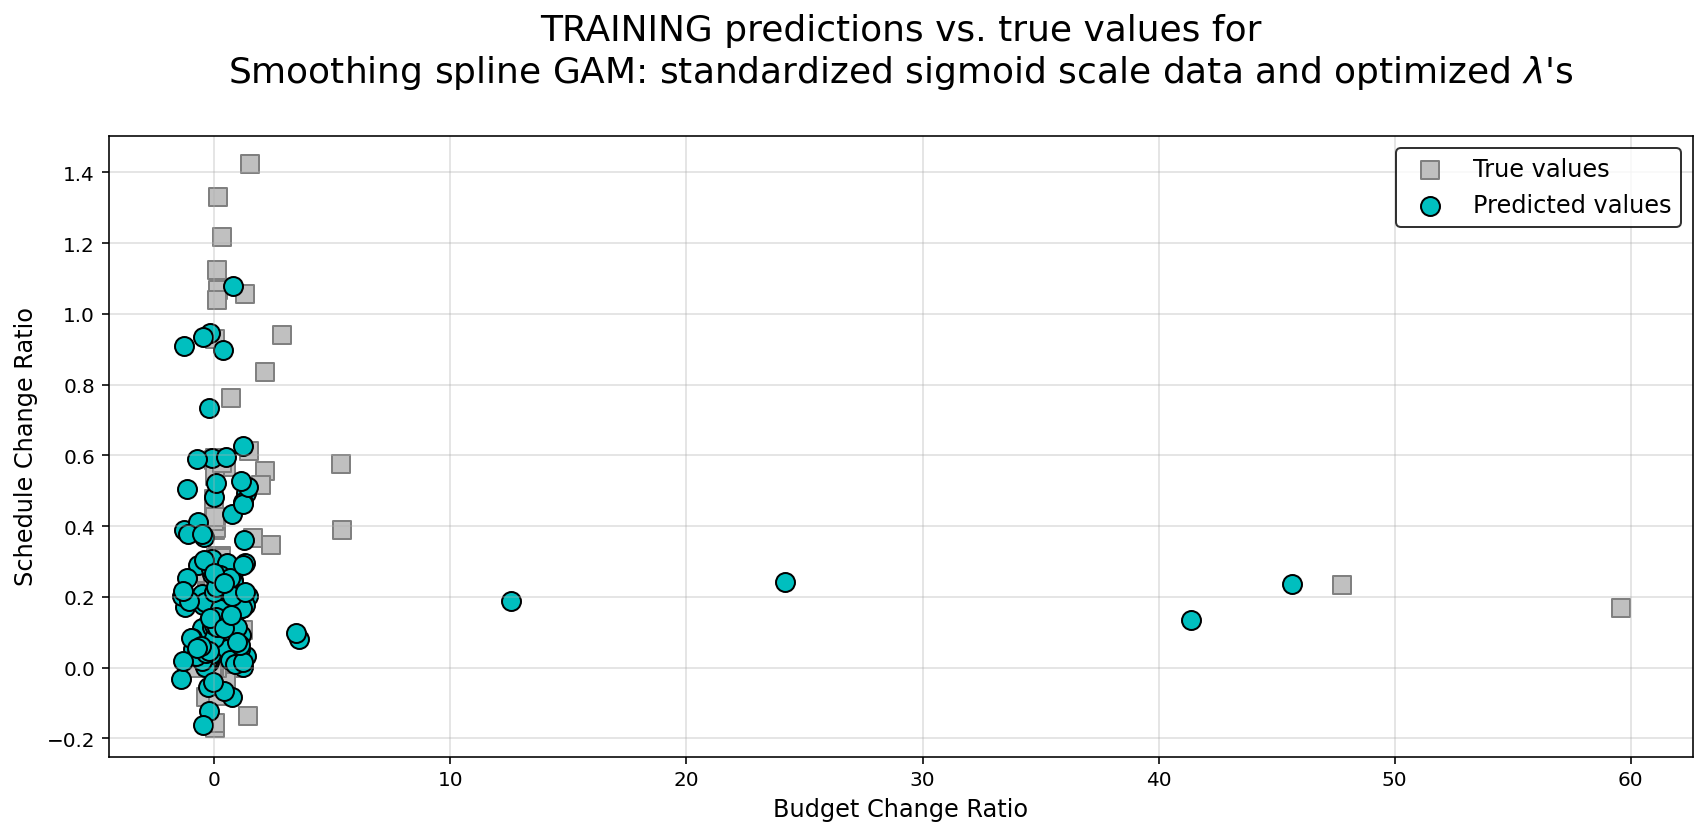

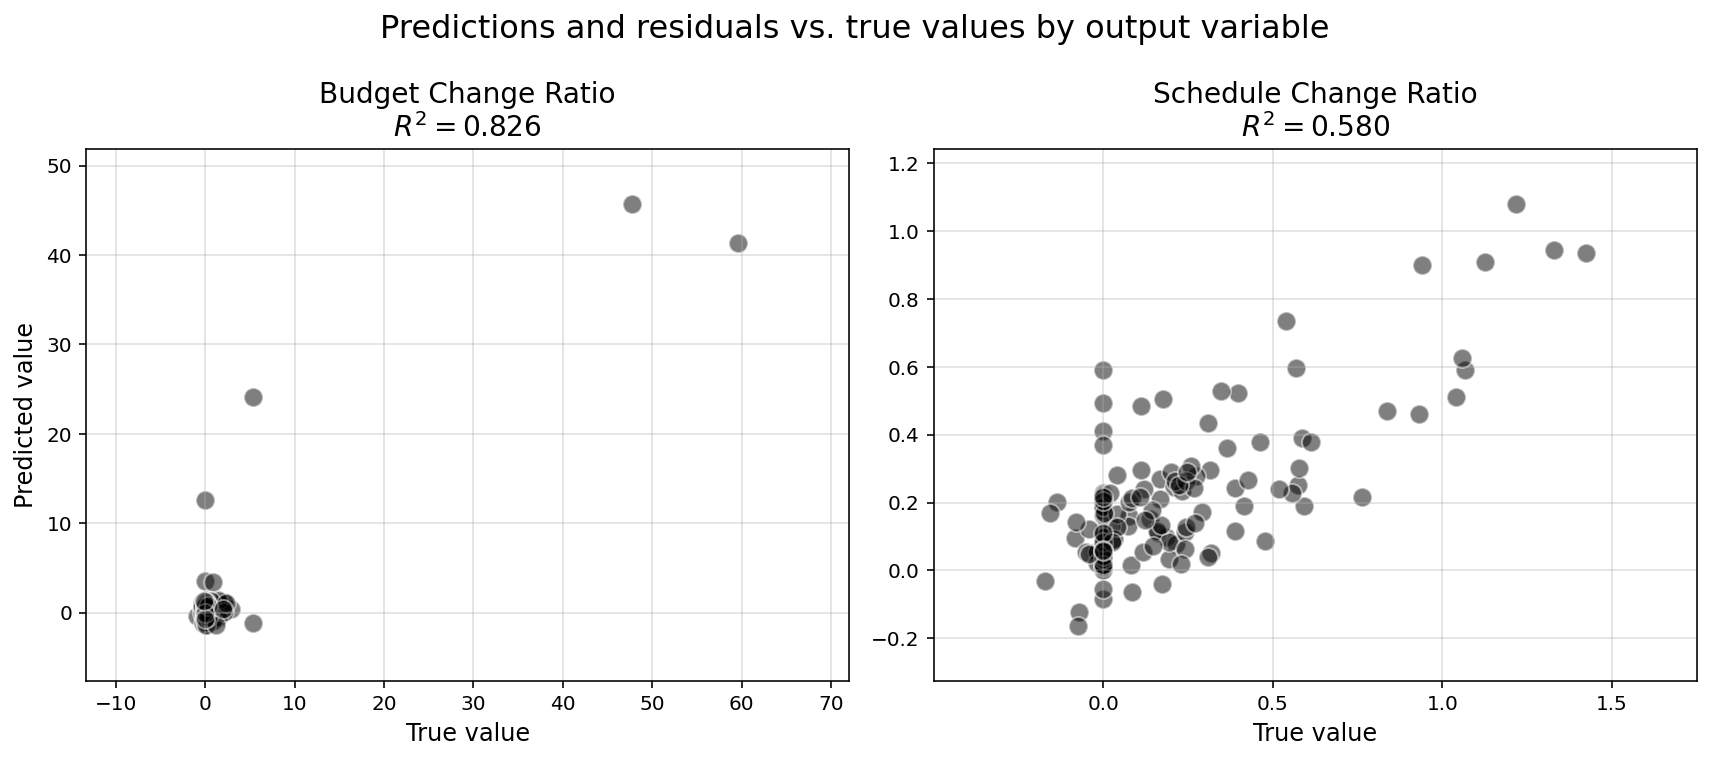

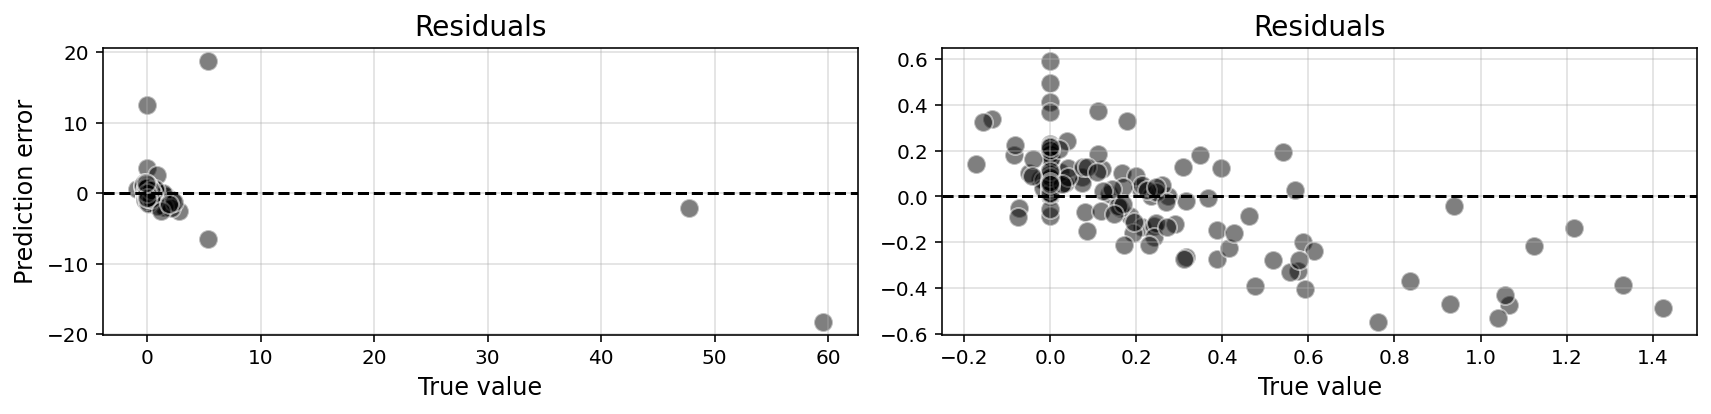

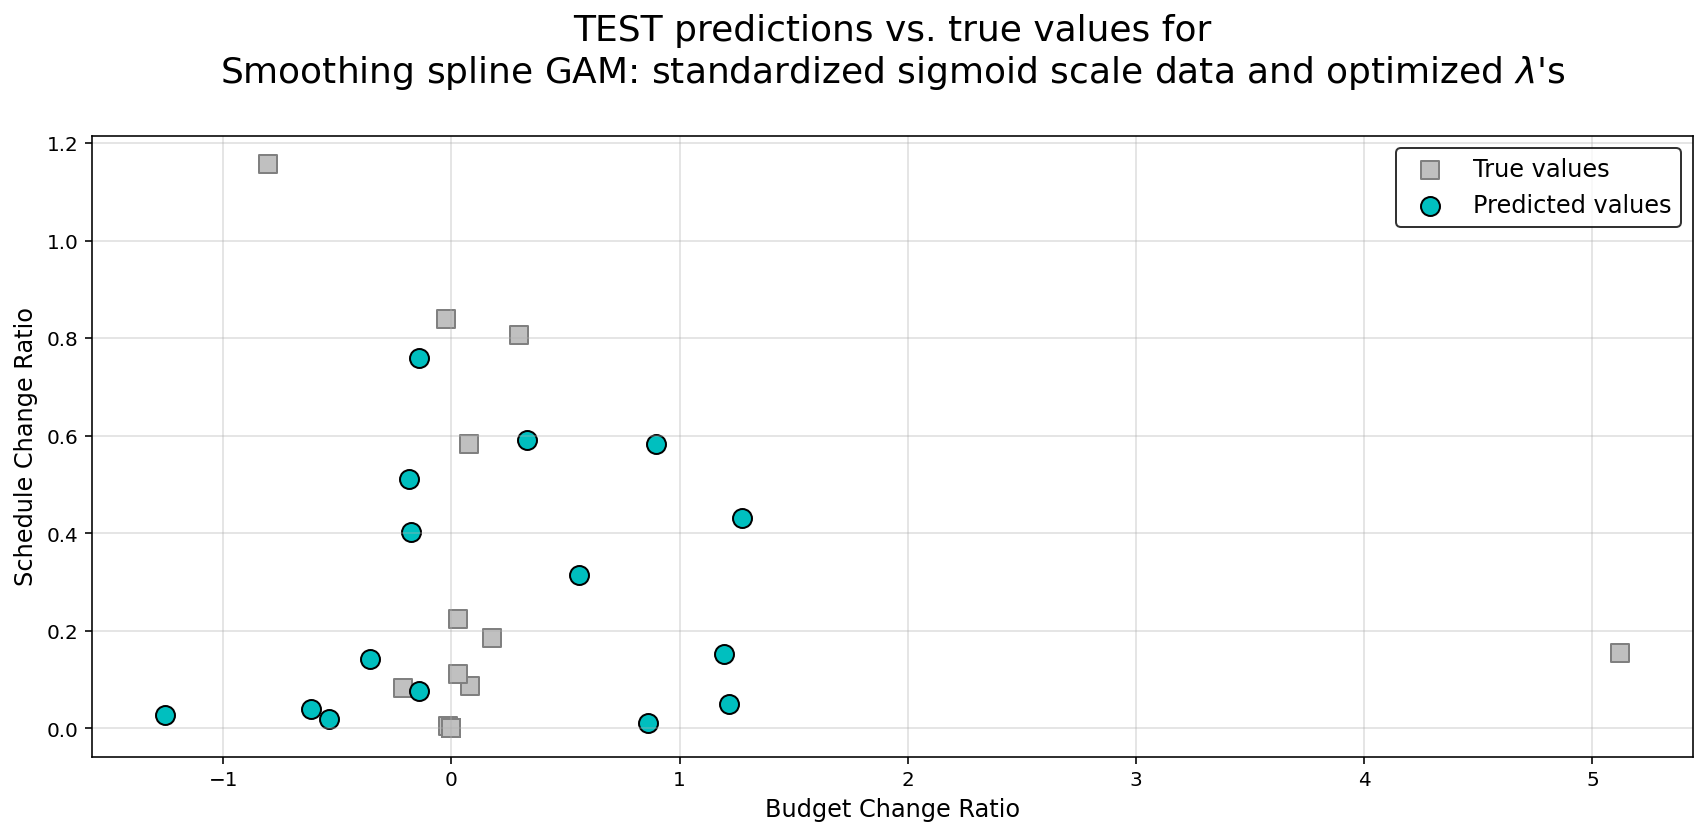

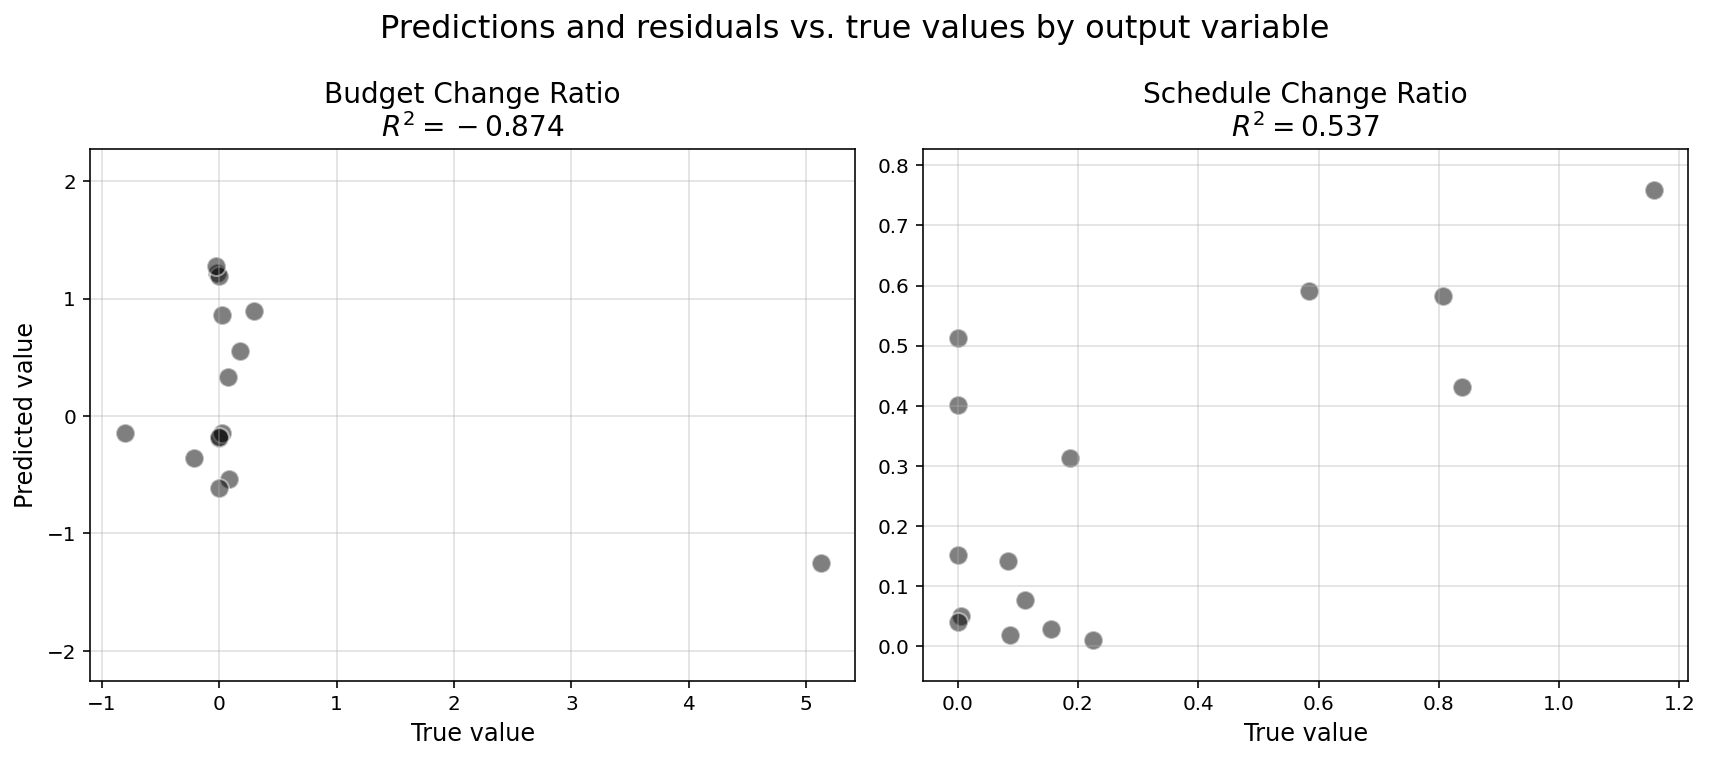

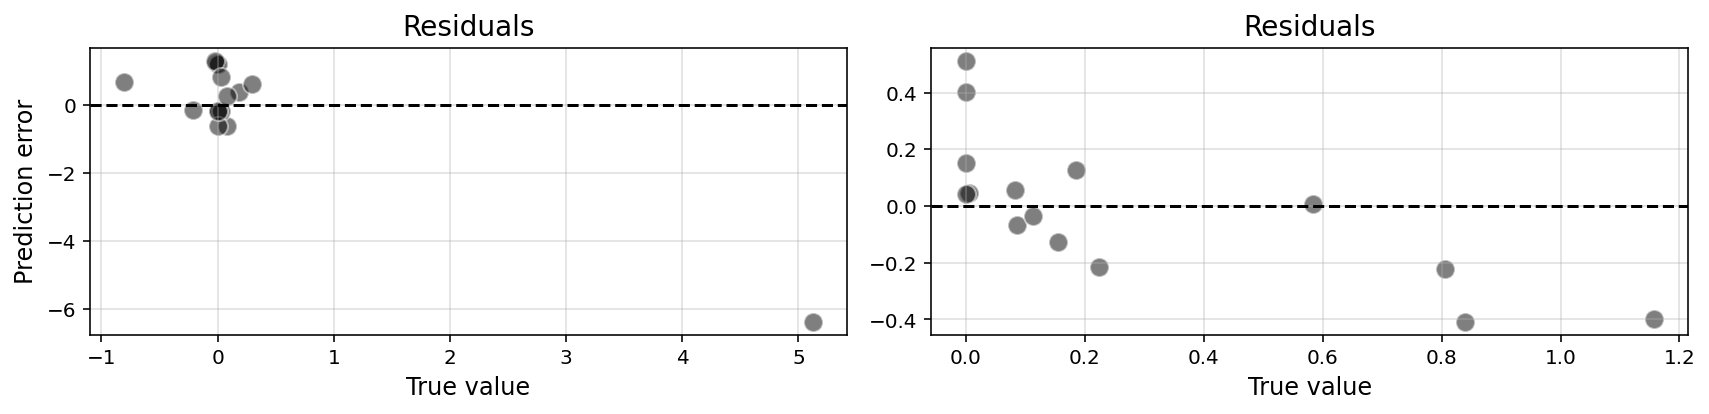

In [45]:
model_descr = "Smoothing spline GAM: standardized sigmoid scale data and optimized $\lambda$'s"
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

In [46]:
def plot_gam_contribution_by_predictor(model_dict, model_index, X_data, y_data,
                                       dataset='train', suptitle_y=1.14):
    """Calculates and plots the partial dependece and 95% CIs for a GAM model
    """
    # reset indices to prevent index match errors
    X_data = X_data.copy().reset_index(drop=True)
    y_data = y_data.copy().reset_index(drop=True)
    
    idx = model_index
    model = model_dict['model'][idx]
    X_varnames = X_data.columns
    y_varname = model_dict['y_variables'][idx].replace('_', ' ')
    model_desc = model_dict['description']
    
    n_X_vars = len(X_varnames)
    n_rows = np.ceil(3/2).astype(int)
    
    # generate deviance residuals
    res = model.deviance_residuals(X_data, y_data.iloc[:, idx])
    
    # plot all predictors against price to visualize relationship
    fig, axes = plt.subplots(n_rows, 2, sharey=False, figsize=(12, 4*n_rows))
    
    plt.suptitle(
        "{} predictions:\nContribution of each predictor to overall function "\
        "(partial dependence and 95% CI)\n{}\n"\
        "Illustrated with {} observations".format(
            y_varname.upper(),
            model_desc,
            'training' if dataset=='train' else 'TEST',
        ),
        fontsize=18,
        y=suptitle_y
    )

    # helper function for specifying left vs right column plots
    if_even = lambda a, b, i: a if i % 2 == 0 else b

    for (i, ax), term in zip(enumerate(axes.flat), model.terms):
        if term.isintercept:
            continue

        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95)
        pdep2, _ = model.partial_dependence(
            term=i, X=X_data, width=0.95
        )

        ax.scatter(
            X_data.iloc[:,term.feature],
            pdep2 + res,
            color='silver',
            alpha=1,
        )
        ax.plot(XX[:, term.feature], pdep, 'k-')
        ax.plot(XX[:, term.feature], confi, c='k', ls='--')

        ax.set_title(X_varnames[i], fontsize=14)
        ax.set_xlabel('observed values', fontsize=12)
        ax.grid(':', alpha=0.4)
        
        if i % 2 == 0:
            ax.set_ylabel('partial dependence', fontsize=12)

    # hide all markings for final missing axes in odd number predictors
    n_fewer = 2 - (n_X_vars + 1) % 2 
    if n_fewer != 0:
        for pos in ['right','top','bottom','left']:
            axes[n_rows-1, -1].spines[pos].set_visible(False)
        axes[n_rows-1, -1].tick_params(
            axis='x', which='both', bottom=False, top=False, labelbottom=False
        )
        axes[n_rows-1, -1].tick_params(
            axis='y', which='both', right=False, left=False, labelleft=False
        )

    plt.tight_layout()
    plt.show()

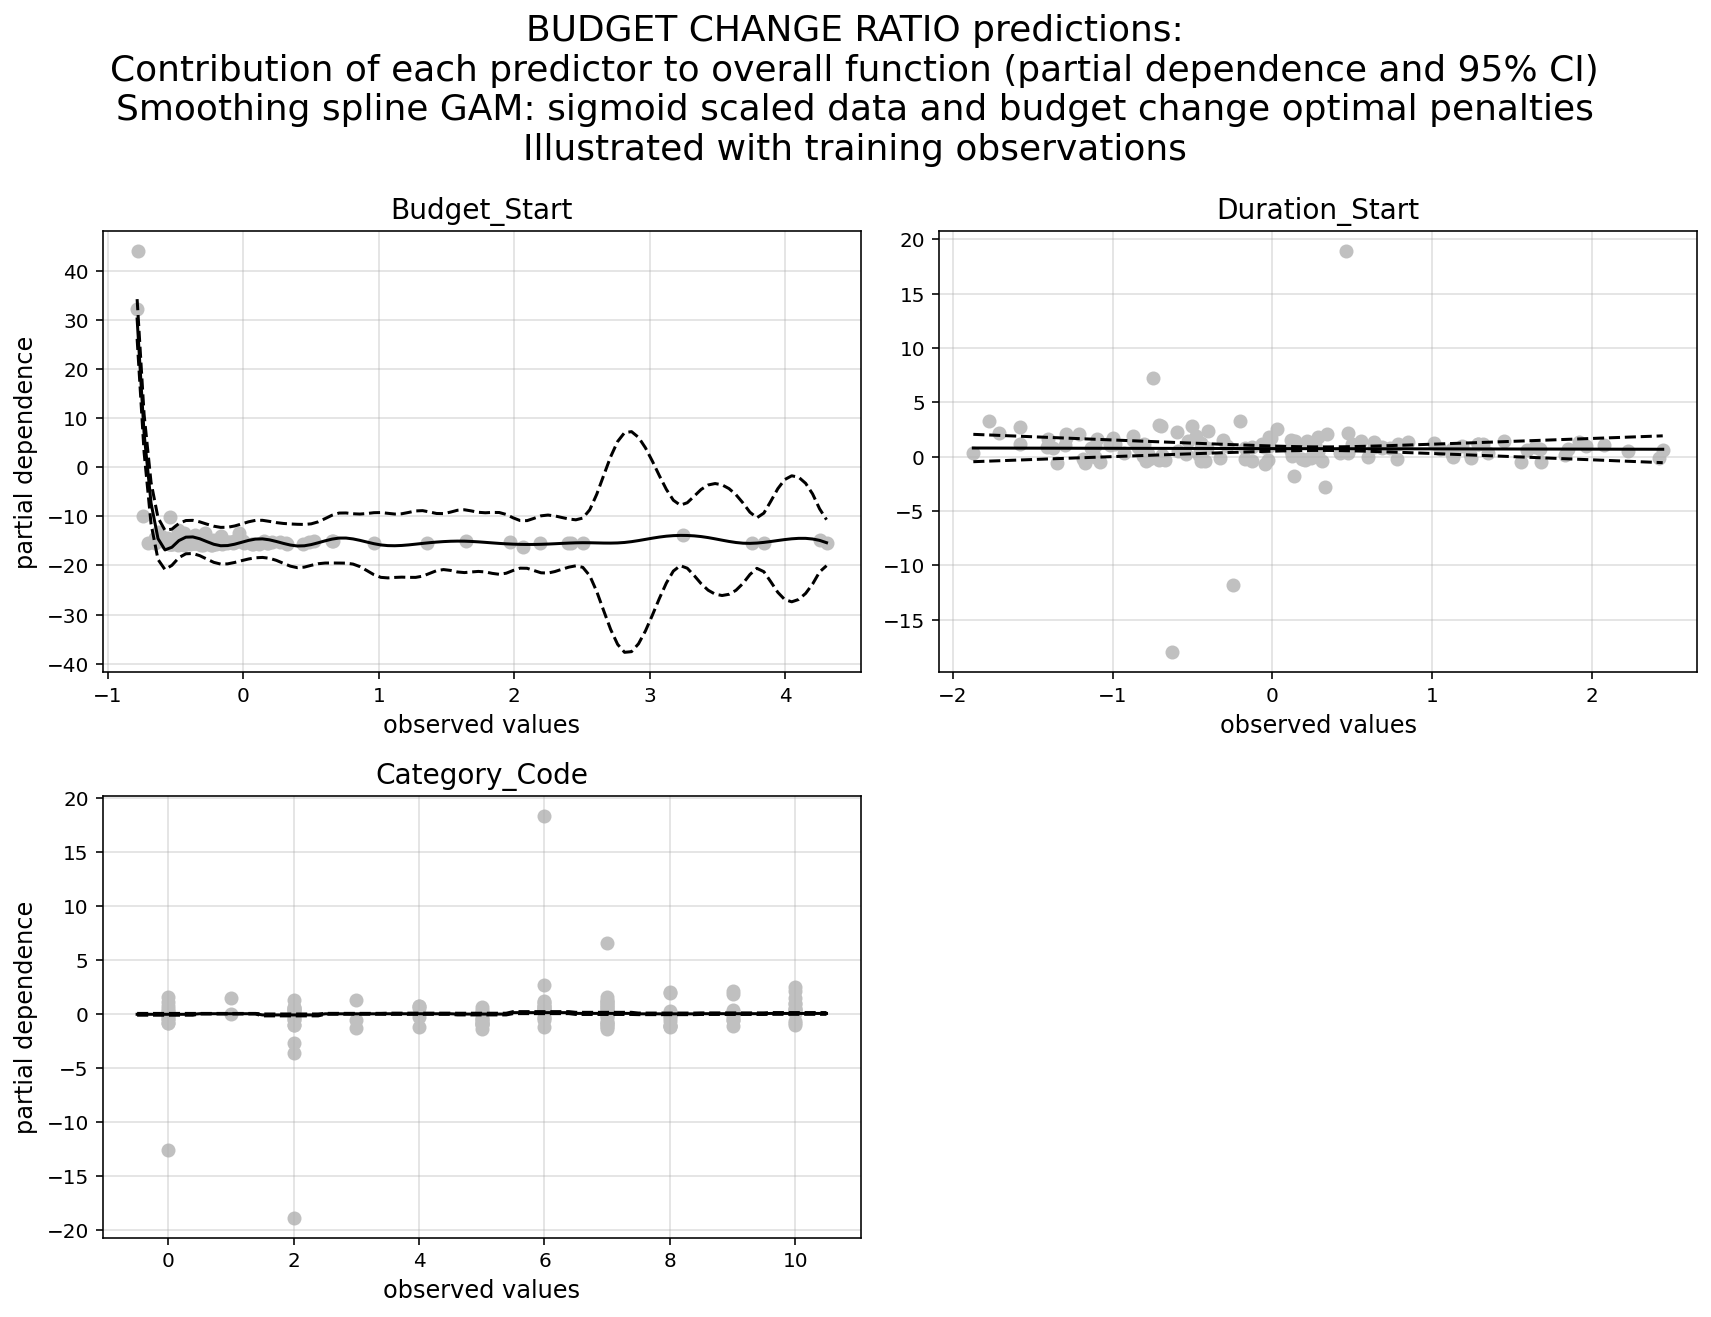

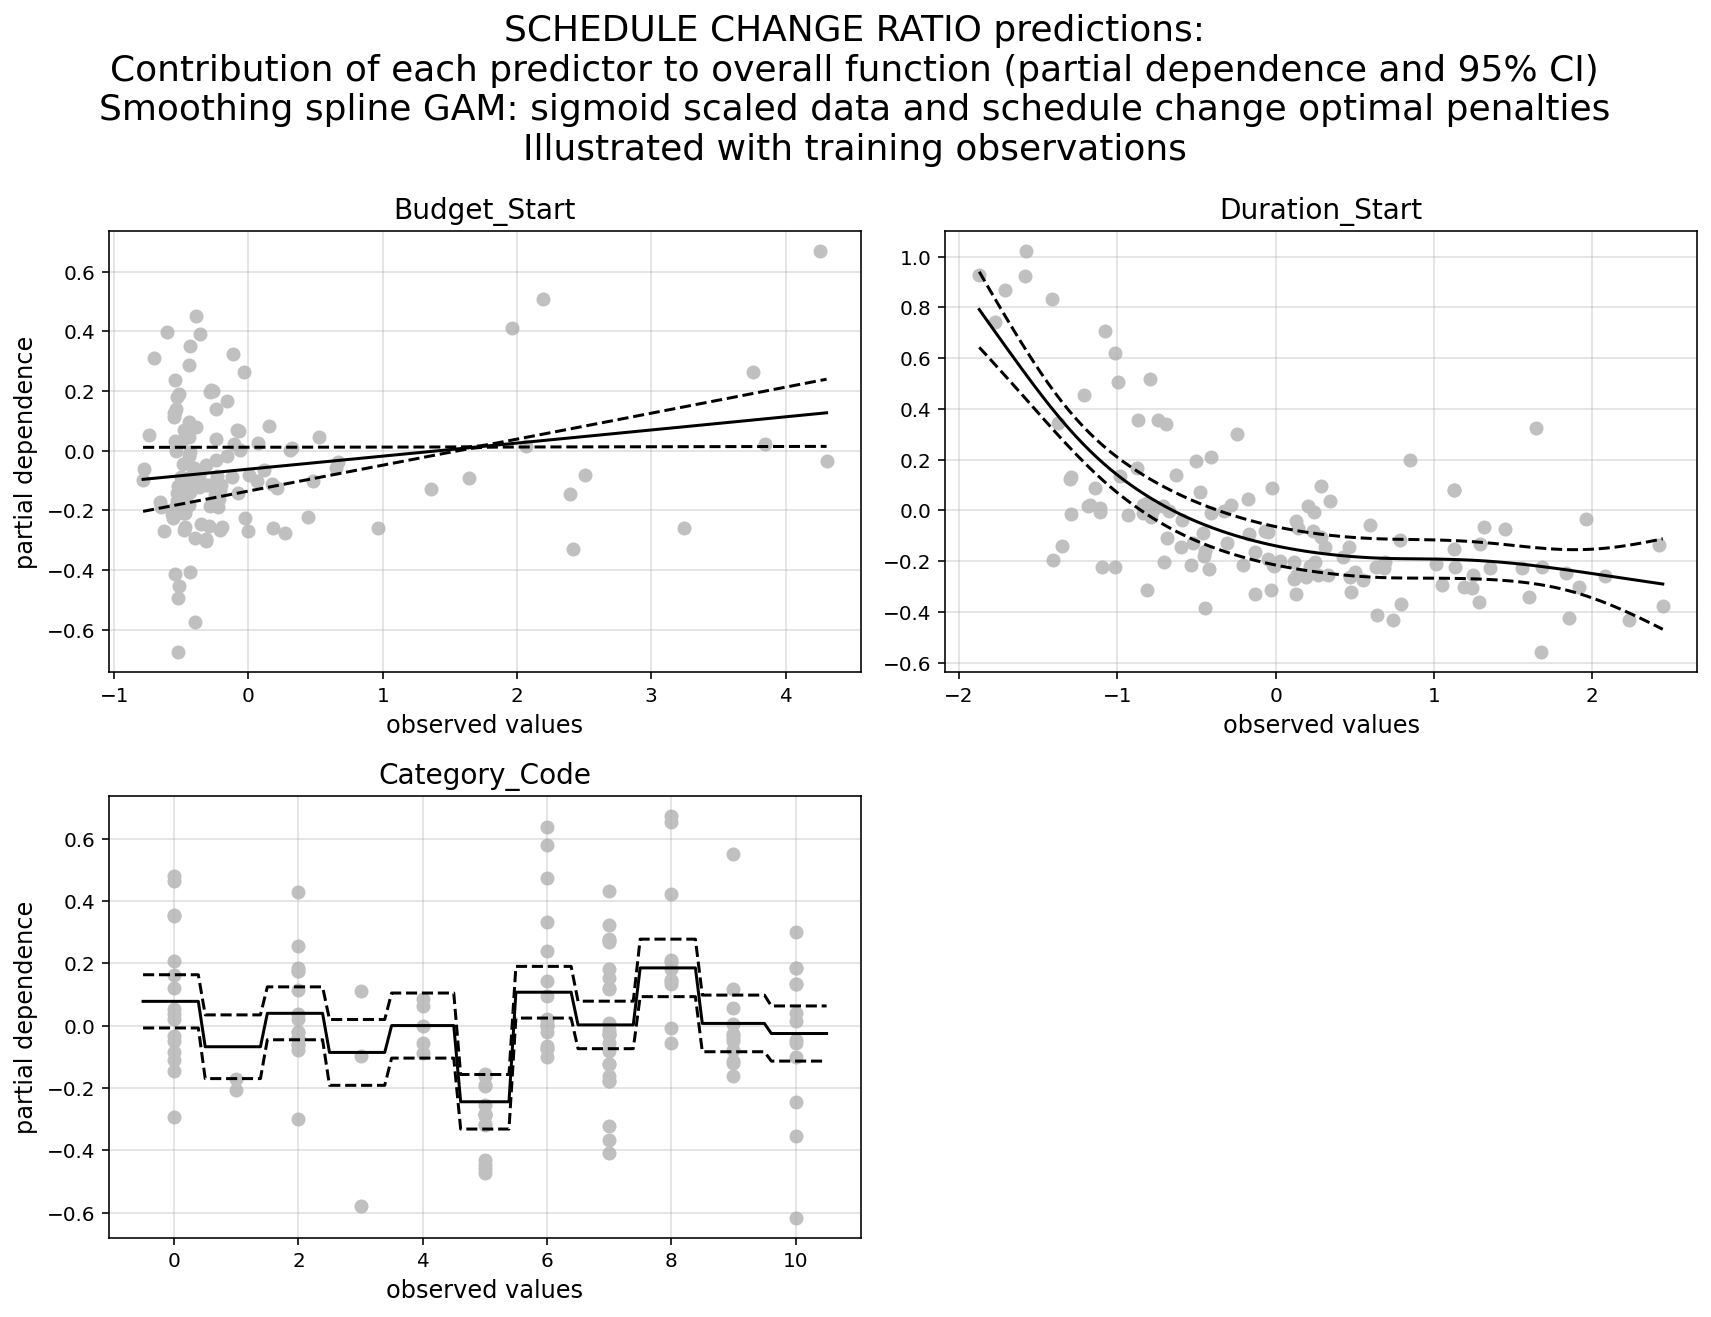

In [47]:
plot_gam_contribution_by_predictor(
    model_dict=model_gam_std_sig1, model_index=0,
    X_data=X_le_tr_std_sig, y_data=y_train,
    dataset='train'
)

print()
plot_gam_contribution_by_predictor(
    model_dict=model_gam_std_sig2, model_index=1,
    X_data=X_le_tr_std_sig, y_data=y_train,
    dataset='train'
)